In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.jla_supernovae_marginalized.jla import *
import simulators.jla_supernovae_marginalized.jla_parser as jla
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# Import data
jla_data, jla_cmats = jla.b14_parse(z_min=None, z_max=None, qual_cut=False,
                                    jla_path='simulators/jla_supernovae_marginalized/jla_data/')
data = jla_data['mb']
delta_m_cut = 10
auxiliary_data = np.column_stack([jla_data['zcmb'], jla_data['x1'], jla_data['color'], np.array([(jla_data['3rdvar'] > delta_m_cut)], dtype=int)[0]])

# Om, w0, M_b, alpha, beta, delta_m
npar = 6
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
Q = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior_args = [prior_mean, Q, lower, upper]

# Covariance matrix
C = jla.b14_covariance(jla_data, jla_cmats, theta_fiducial[3], theta_fiducial[4])
Cinv = np.linalg.inv(C)
L = np.linalg.cholesky(C)

# Derivative of the covariance matrix
n_sn = len(C)
dCdt = np.zeros((npar, n_sn, n_sn))

# Step size for derivatives
step = abs(0.01*theta_fiducial)

# N data points
ndata = len(jla_data['mb'])

# Simulation args
sim_args = [auxiliary_data, L]

# Compute the mean
mu = apparent_magnitude(theta_fiducial, auxiliary_data)

# Compute the derivatives
dmdt = dmudtheta(theta_fiducial, simulation_seeded, step, npar, ndata, sim_args)
dmdt[2,:] = np.ones(n_sn)
dmdt[3,:] = -jla_data['x1']
dmdt[4,:] = jla_data['color']
dmdt[5,:] = (jla_data['3rdvar'] > 10)

# Fisher matrix
F, Finv = fisher(dmdt, dCdt, Cinv, Qinv, npar)
fisher_errors = np.sqrt(np.diag(Finv))

# Compute projection vectors
Fpinv = np.linalg.inv(F[2:,2:])
P1 = np.dot(Fpinv, F[0,2:])
P2 = np.dot(Fpinv, F[1,2:])

# Simulation args for ABC
simABC_args = [theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, sim_args, P1, P2, F, prior_args]

# Compressed dataset
data_observed = mle(theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, data)

# Do the projection of the data
data_observed = np.dot(F, data_observed - theta_fiducial - np.dot(Finv, np.dot(Qinv, prior_mean - theta_fiducial)))
data_observed = np.dot(Finv[0:2, 0:2], np.array([data_observed[0] - np.dot(P1, data_observed[2:]), data_observed[1] - np.dot(P2, data_observed[2:])]))
data_observed = data_observed + theta_fiducial[:2] + np.dot(Finv[:2,:2], np.dot(Qinv[:2,:2], prior_mean[:2] - theta_fiducial[:2]))
data = data_observed

/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI/simulators/jla_supernovae_marginalized/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [4]:
# Create prior over parameters
lower = np.array([0, -1.5])
upper = np.array([0.6, 0])
Q = np.diag([0.4, 0.75])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([0.3, -0.75])
Finv = Finv[0:2,0:2]
theta_fiducial = np.array([0.20181324,  -0.74762939])
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [5]:
# Create the DELFI MDN object
n_components = 3
names = ['\Omega_m', 'w_0']
labels =  ['\\Omega_m', 'w_0']
ranges = {'\Omega_m':[lower[0], upper[0]], '\w0':[lower[1], upper[1]]}

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 66s 1ms/step - loss: 1.9290 - val_loss: 1.5450
Epoch 2/50
45000/45000 [==============================] - 66s 1ms/step - loss: 1.4949 - val_loss: 1.4699
Epoch 3/50
45000/45000 [==============================] - 63s 1ms/step - loss: 1.4691 - val_loss: 1.4861
Epoch 4/50
45000/45000 [==============================] - 61s 1ms/step - loss: 1.4608 - val_loss: 1.4615
Epoch 5/50
45000/45000 [==============================] - 62s 1ms/step - loss: 1.4547 - val_loss: 1.4521
Epoch 6/50
45000/45000 [==============================] - 63s 1ms/step - loss: 1.4532 - val_loss: 1.4438
Epoch 7/50
45000/45000 [==============================] - 61s 1ms/step - loss: 1.4496 - val_loss: 1.4579
Epoch 8/50
45000/45000 [==============================] - 60s 1ms/step - loss: 1.4504 - val_loss: 1.4599
Epoch 9/50
45000/45000 [==============================] - 61s 1ms/step - l

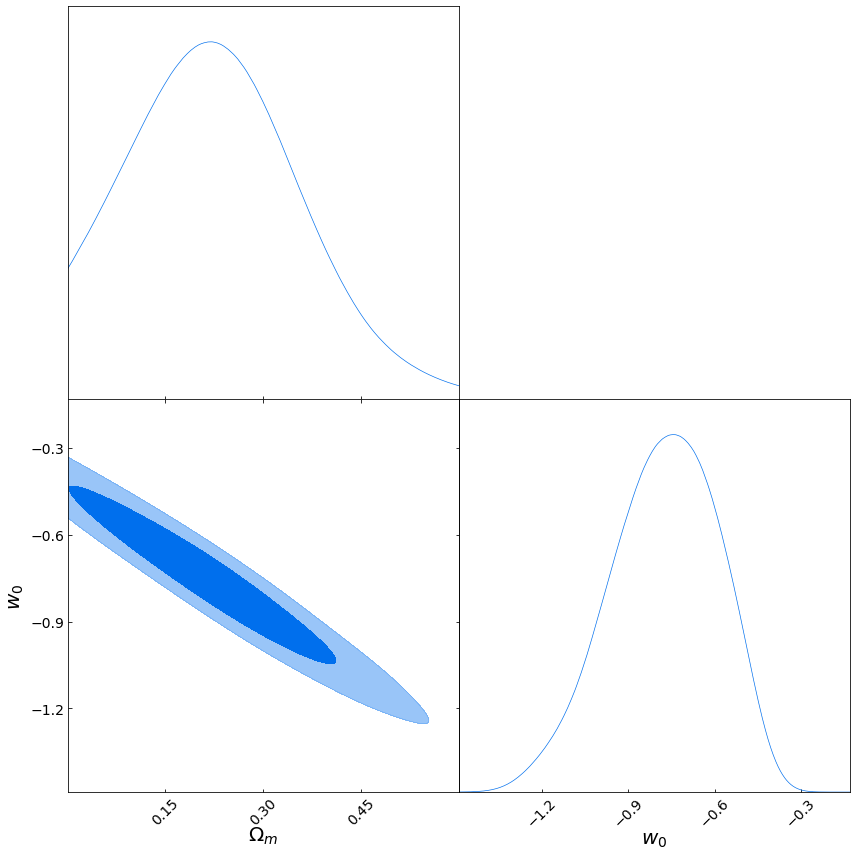

In [6]:
# Proposal for the Fisher pre-training stage
proposal = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Do the Fisher pre-training
mdn.fisher_pretraining(50000, proposal, epochs=50)

Running initial 200 sims...
Done.
Train on 180 samples, validate on 20 samples
Epoch 1/100
180/180 [==============================] - 0s 1ms/step - loss: 2.6784 - val_loss: 2.3837
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 2.1752 - val_loss: 1.8840
Epoch 3/100
180/180 [==============================] - 0s 1ms/step - loss: 1.8978 - val_loss: 1.7831
Epoch 4/100
180/180 [==============================] - 0s 2ms/step - loss: 1.7948 - val_loss: 1.8508
Epoch 5/100
180/180 [==============================] - 0s 1ms/step - loss: 1.7239 - val_loss: 1.7145
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 1.6827 - val_loss: 1.6176
Epoch 7/100
180/180 [==============================] - 0s 1ms/step - loss: 1.5842 - val_loss: 1.5788
Epoch 8/100
180/180 [==============================] - 0s 2ms/step - loss: 1.5455 - val_loss: 1.6966
Epoch 9/100
180/180 [==============================] - 0s 1ms/step - loss: 1.5123 - val_loss: 1.5125
Epoch 10/100

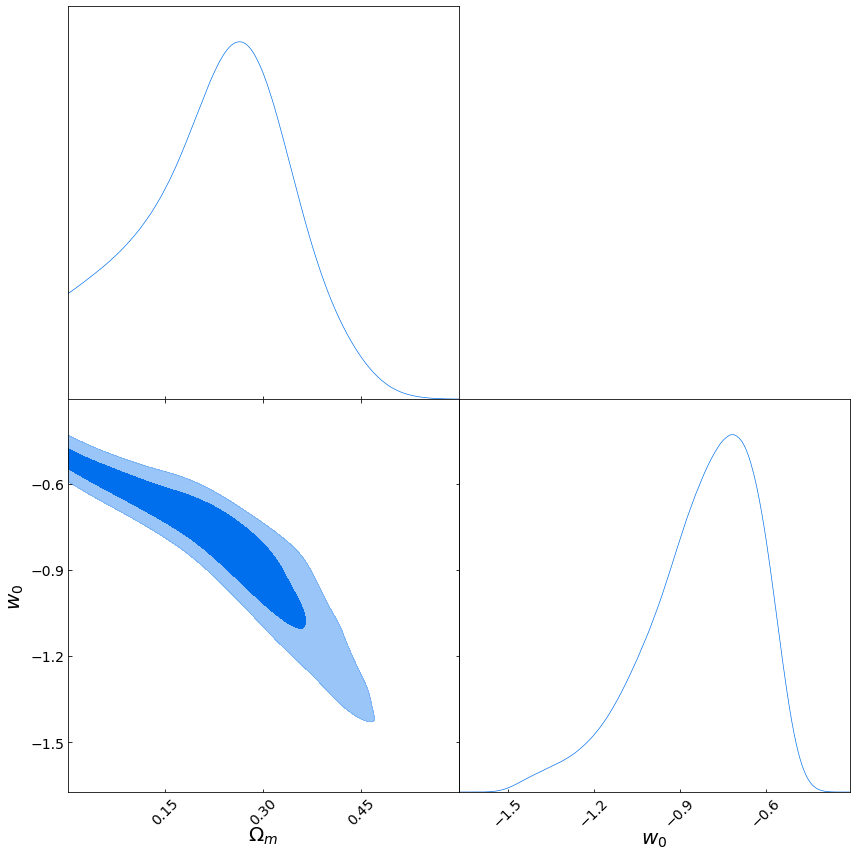

Population 1/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 360 samples, validate on 40 samples
Epoch 1/100
360/360 [==============================] - 1s 1ms/step - loss: 1.4567 - val_loss: 1.3300
Epoch 2/100
360/360 [==============================] - 1s 2ms/step - loss: 1.4276 - val_loss: 1.3511
Epoch 3/100
360/360 [==============================] - 1s 2ms/step - loss: 1.4445 - val_loss: 1.3026
Epoch 4/100
360/360 [==============================] - 1s 2ms/step - loss: 1.4435 - val_loss: 1.3522
Epoch 5/100
360/360 [==============================] - 1s 2ms/step - loss: 1.4077 - val_loss: 1.3048
Epoch 6/100
360/360 [==============================] - 1s 2ms/step - loss: 1.4196 - val_loss: 1.3081
Epoch 7/100
360/360 [==============================] - 1s 1ms/step - loss: 1.4038 - val_loss: 1.2707
Epoch 8/100
360/360 [==============================] - 1s 2ms/step - loss: 1.3939 - val_loss: 1.3172
Epoch 9/100
360/360 [==============================] - 1s 1ms/step - l

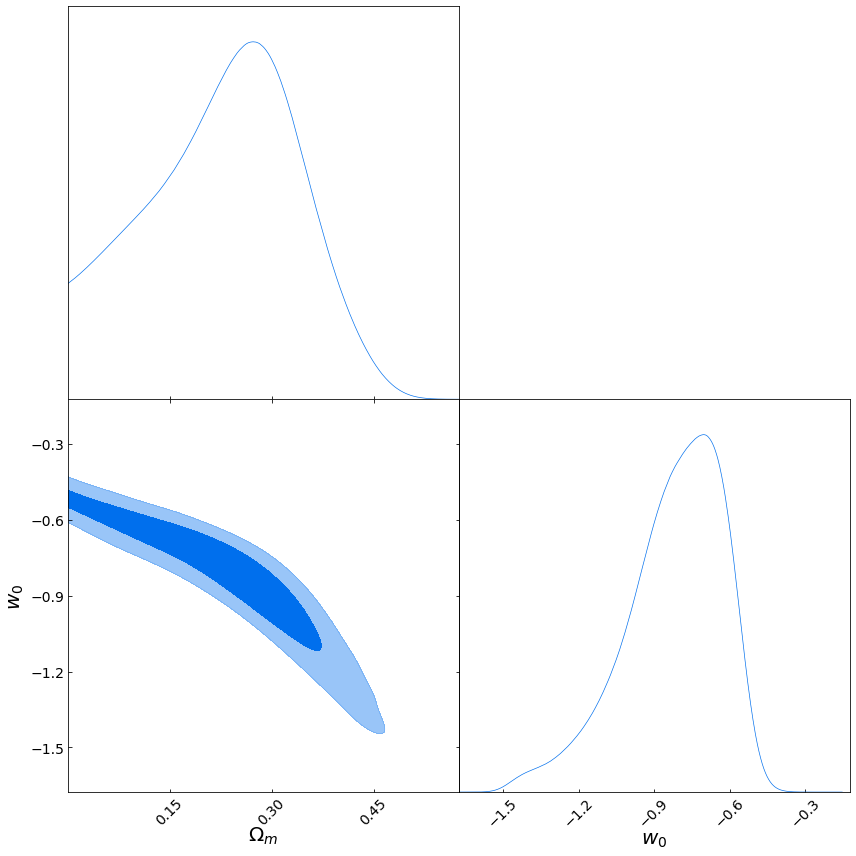

Population 2/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 540 samples, validate on 60 samples
Epoch 1/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3957 - val_loss: 1.3912
Epoch 2/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3728 - val_loss: 1.4006
Epoch 3/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3732 - val_loss: 1.4149
Epoch 4/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3536 - val_loss: 1.4312
Epoch 5/100
540/540 [==============================] - 1s 2ms/step - loss: 1.3514 - val_loss: 1.3892
Epoch 6/100
540/540 [==============================] - 1s 2ms/step - loss: 1.3535 - val_loss: 1.4089
Epoch 7/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3459 - val_loss: 1.4243
Epoch 8/100
540/540 [==============================] - 1s 1ms/step - loss: 1.3506 - val_loss: 1.4265
Epoch 9/100
540/540 [==============================] - 1s 1ms/step - l

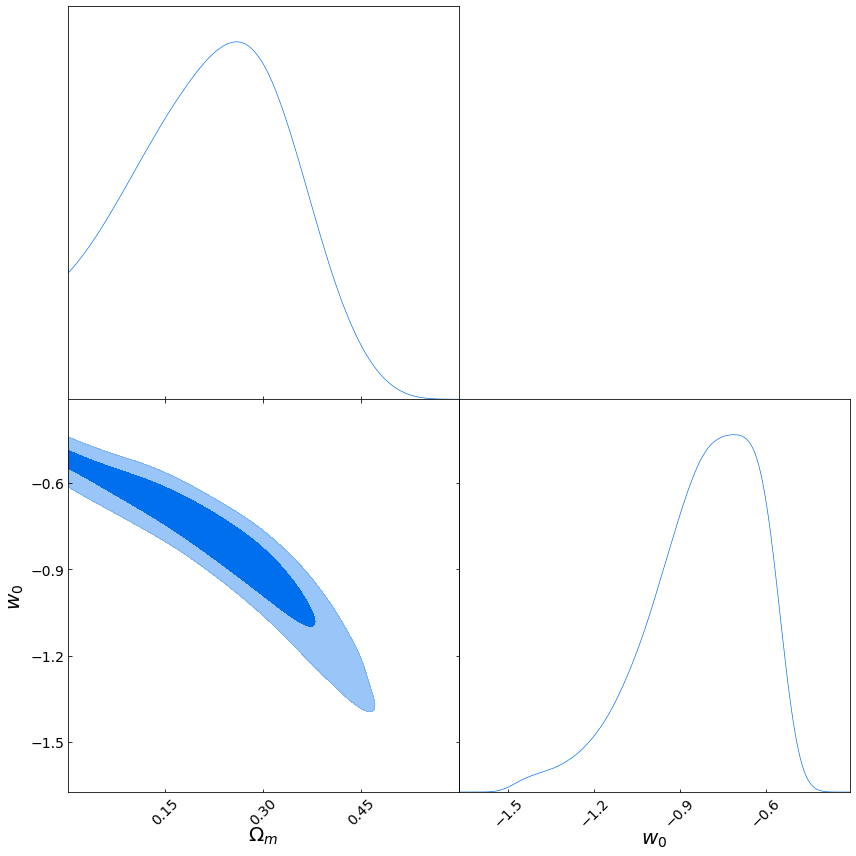

Population 3/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3579 - val_loss: 1.4528
Epoch 2/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3636 - val_loss: 1.4582
Epoch 3/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3661 - val_loss: 1.4517
Epoch 4/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3529 - val_loss: 1.4414
Epoch 5/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3495 - val_loss: 1.4463
Epoch 6/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3489 - val_loss: 1.4426
Epoch 7/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3479 - val_loss: 1.4514
Epoch 8/100
720/720 [==============================] - 1s 1ms/step - loss: 1.3477 - val_loss: 1.4496
Epoch 9/100
720/720 [==============================] - 1s 1ms/step - l

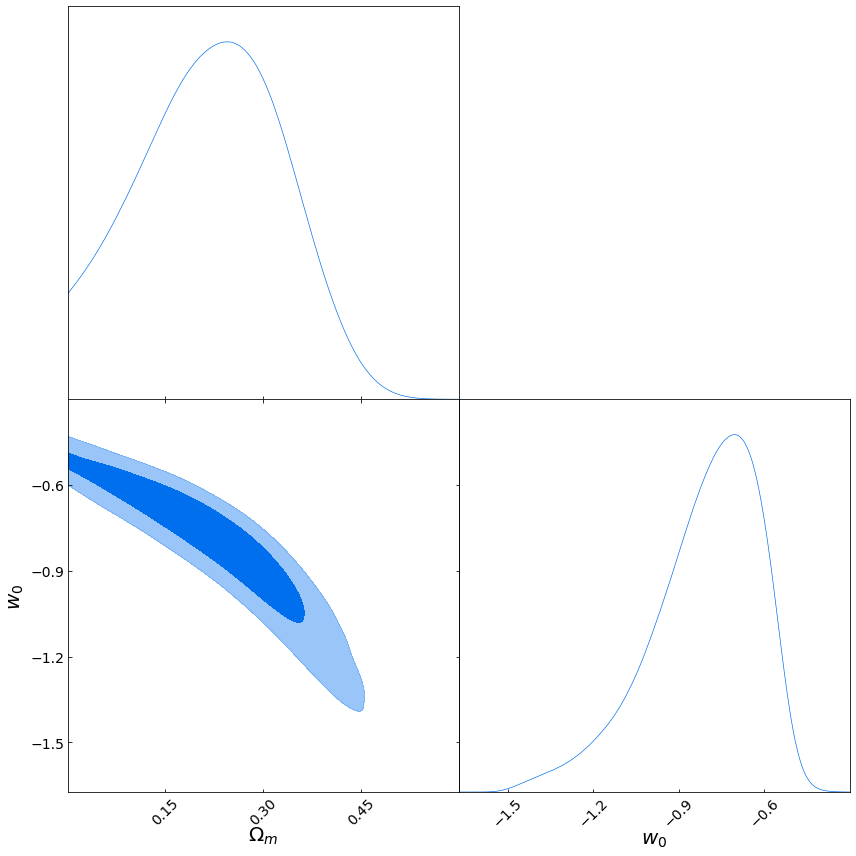

Population 4/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 2s 2ms/step - loss: 1.3515 - val_loss: 1.4061
Epoch 2/100
900/900 [==============================] - 1s 2ms/step - loss: 1.3541 - val_loss: 1.3997
Epoch 3/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3474 - val_loss: 1.4066
Epoch 4/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3459 - val_loss: 1.4059
Epoch 5/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3490 - val_loss: 1.4163
Epoch 6/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3600 - val_loss: 1.3926
Epoch 7/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3588 - val_loss: 1.4094
Epoch 8/100
900/900 [==============================] - 1s 1ms/step - loss: 1.3492 - val_loss: 1.3993
Epoch 9/100
900/900 [==============================] - 1s 1ms/step - 

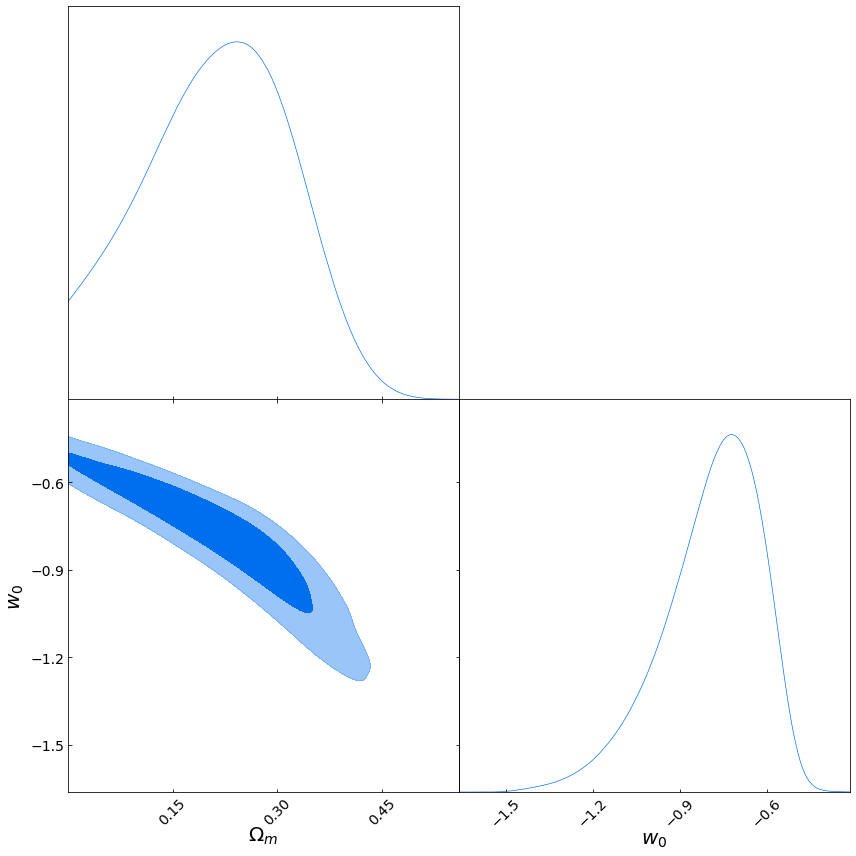

Population 5/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1080 samples, validate on 120 samples
Epoch 1/100
1080/1080 [==============================] - 3s 3ms/step - loss: 1.3433 - val_loss: 1.1795
Epoch 2/100
1080/1080 [==============================] - 4s 3ms/step - loss: 1.3453 - val_loss: 1.1654
Epoch 3/100
1080/1080 [==============================] - 3s 3ms/step - loss: 1.3454 - val_loss: 1.1604
Epoch 4/100
1080/1080 [==============================] - 3s 3ms/step - loss: 1.3430 - val_loss: 1.1570
Epoch 5/100
1080/1080 [==============================] - 3s 3ms/step - loss: 1.3423 - val_loss: 1.1650
Epoch 6/100
1080/1080 [==============================] - 3s 3ms/step - loss: 1.3417 - val_loss: 1.1607
Epoch 7/100
1080/1080 [==============================] - 4s 4ms/step - loss: 1.3467 - val_loss: 1.1789
Epoch 8/100
1080/1080 [==============================] - 5s 5ms/step - loss: 1.3448 - val_loss: 1.1645
Epoch 9/100
1080/1080 [=============================

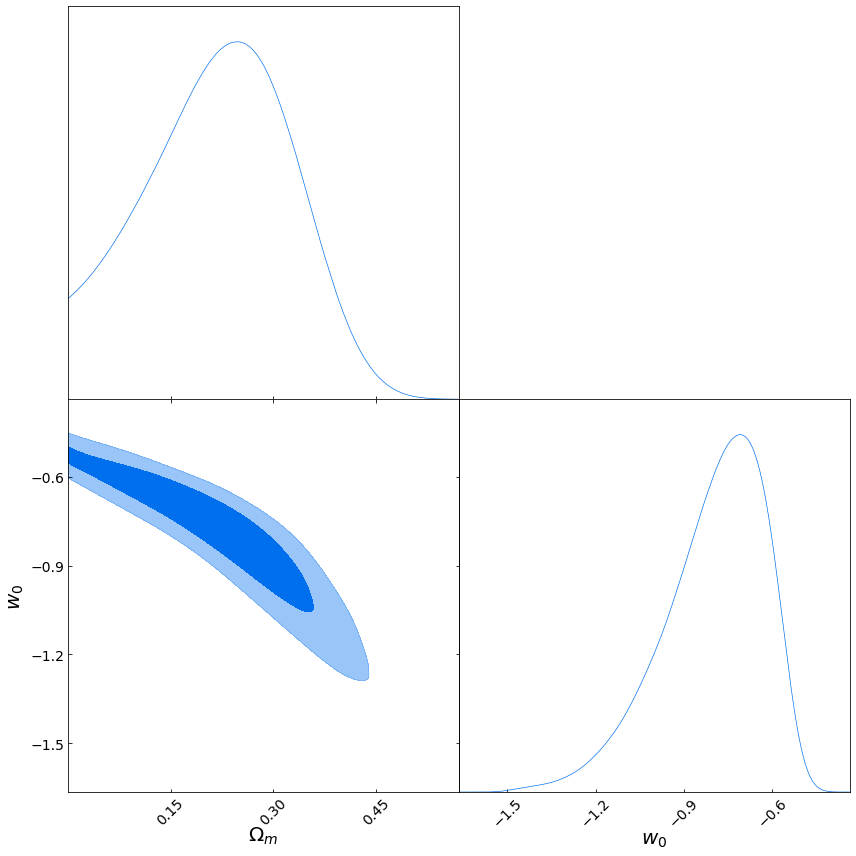

Population 6/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1260 samples, validate on 140 samples
Epoch 1/100
1260/1260 [==============================] - 4s 3ms/step - loss: 1.3154 - val_loss: 1.4105
Epoch 2/100
1260/1260 [==============================] - 3s 3ms/step - loss: 1.3110 - val_loss: 1.4123
Epoch 3/100
1260/1260 [==============================] - 3s 2ms/step - loss: 1.3128 - val_loss: 1.4098
Epoch 4/100
1260/1260 [==============================] - 3s 2ms/step - loss: 1.3122 - val_loss: 1.4063
Epoch 5/100
1260/1260 [==============================] - 3s 2ms/step - loss: 1.3173 - val_loss: 1.4153
Epoch 6/100
1260/1260 [==============================] - 3s 2ms/step - loss: 1.3164 - val_loss: 1.4071
Epoch 7/100
1260/1260 [==============================] - 3s 2ms/step - loss: 1.3237 - val_loss: 1.4130
Epoch 8/100
1260/1260 [==============================] - 3s 2ms/step - loss: 1.3147 - val_loss: 1.4212
Epoch 9/100
1260/1260 [=============================

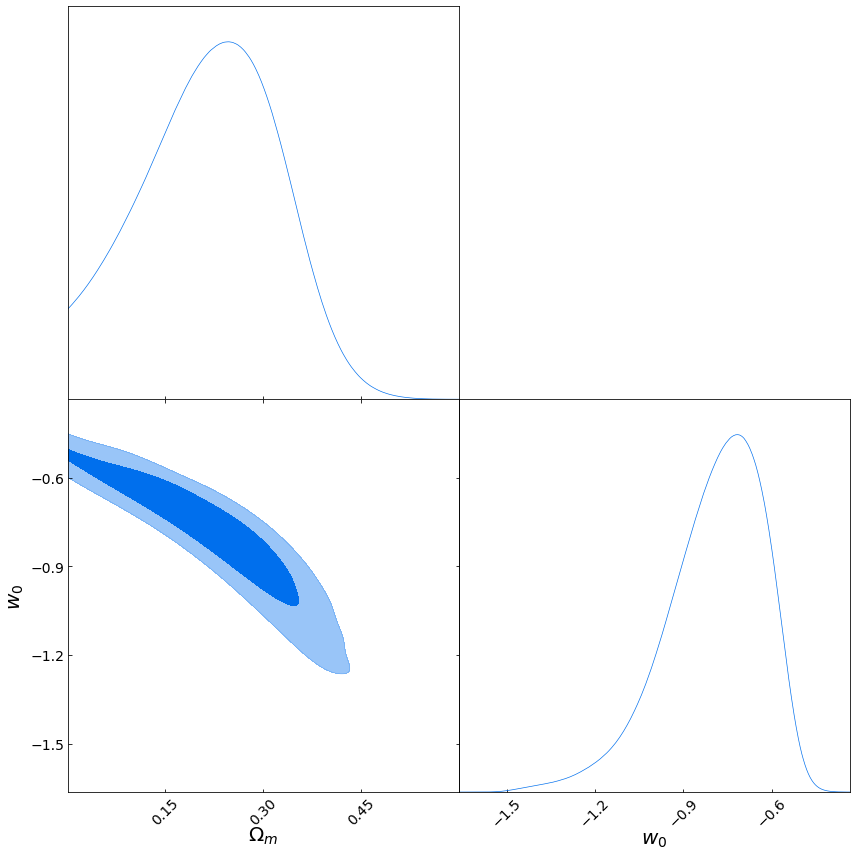

Population 7/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1440 samples, validate on 160 samples
Epoch 1/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3287 - val_loss: 1.3350
Epoch 2/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3221 - val_loss: 1.3184
Epoch 3/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3208 - val_loss: 1.3094
Epoch 4/100
1440/1440 [==============================] - 2s 1ms/step - loss: 1.3182 - val_loss: 1.3157
Epoch 5/100
1440/1440 [==============================] - 3s 2ms/step - loss: 1.3182 - val_loss: 1.3091
Epoch 6/100
1440/1440 [==============================] - 4s 3ms/step - loss: 1.3171 - val_loss: 1.3169
Epoch 7/100
1440/1440 [==============================] - 4s 3ms/step - loss: 1.3146 - val_loss: 1.3253
Epoch 8/100
1440/1440 [==============================] - 4s 3ms/step - loss: 1.3199 - val_loss: 1.3232
Epoch 9/100
1440/1440 [=============================

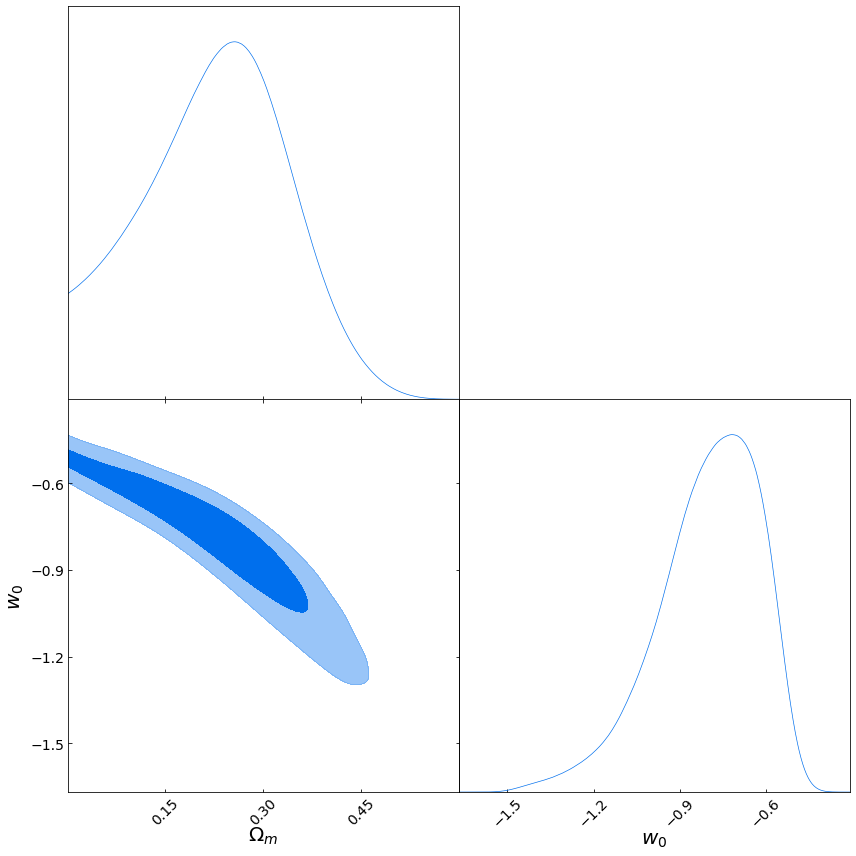

Population 8/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1620 samples, validate on 180 samples
Epoch 1/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3278 - val_loss: 1.3254
Epoch 2/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3255 - val_loss: 1.3598
Epoch 3/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3167 - val_loss: 1.3342
Epoch 4/100
1620/1620 [==============================] - 3s 2ms/step - loss: 1.3155 - val_loss: 1.3316
Epoch 5/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3138 - val_loss: 1.3361
Epoch 6/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3132 - val_loss: 1.3331
Epoch 7/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3150 - val_loss: 1.3287
Epoch 8/100
1620/1620 [==============================] - 2s 1ms/step - loss: 1.3143 - val_loss: 1.3376
Epoch 9/100
1620/1620 [=============================

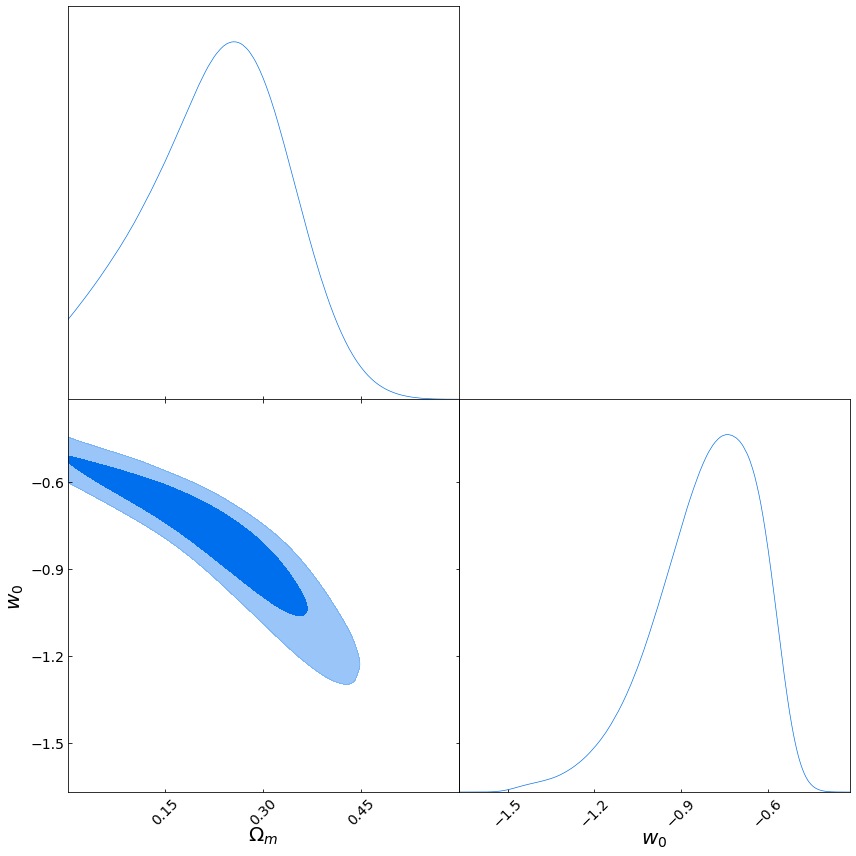

Population 9/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 4s 2ms/step - loss: 1.3149 - val_loss: 1.2939
Epoch 2/100
1800/1800 [==============================] - 3s 1ms/step - loss: 1.3211 - val_loss: 1.2998
Epoch 3/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.3169 - val_loss: 1.3095
Epoch 4/100
1800/1800 [==============================] - 4s 2ms/step - loss: 1.3218 - val_loss: 1.2988
Epoch 5/100
1800/1800 [==============================] - 5s 3ms/step - loss: 1.3135 - val_loss: 1.3003
Epoch 6/100
1800/1800 [==============================] - 4s 2ms/step - loss: 1.3175 - val_loss: 1.2938
Epoch 7/100
1800/1800 [==============================] - 3s 1ms/step - loss: 1.3149 - val_loss: 1.3011
Epoch 8/100
1800/1800 [==============================] - 3s 1ms/step - loss: 1.3189 - val_loss: 1.2975
Epoch 9/100
1800/1800 [=============================

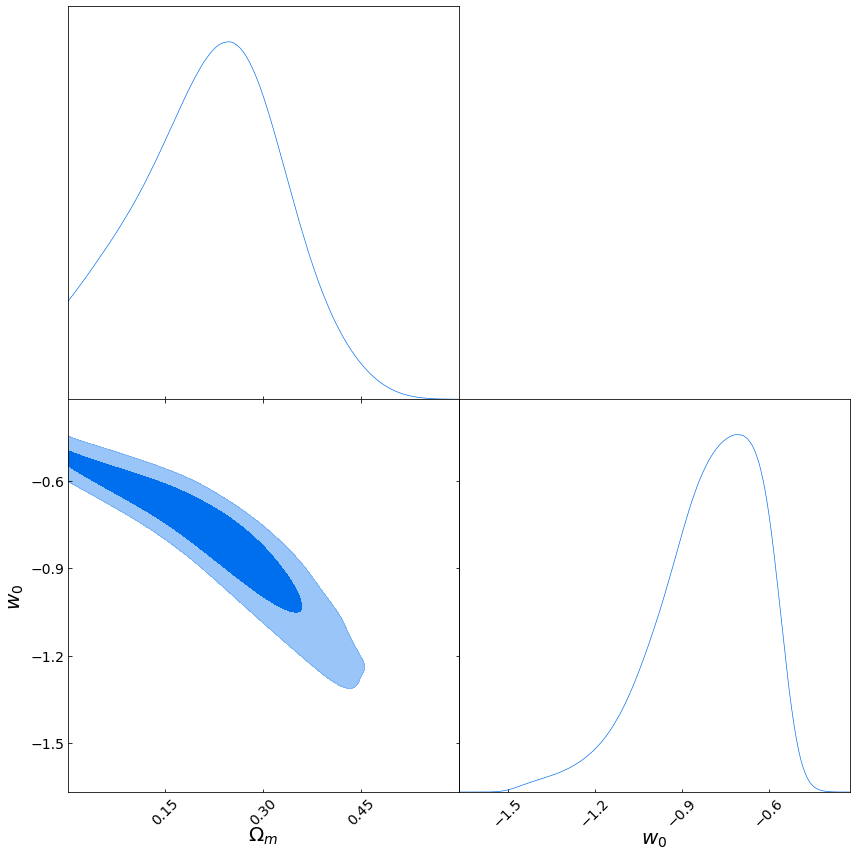

Population 10/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 1980 samples, validate on 220 samples
Epoch 1/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3100 - val_loss: 1.3694
Epoch 2/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3076 - val_loss: 1.3787
Epoch 3/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3110 - val_loss: 1.3799
Epoch 4/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3145 - val_loss: 1.3896
Epoch 5/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3188 - val_loss: 1.3730
Epoch 6/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3177 - val_loss: 1.3807
Epoch 7/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3147 - val_loss: 1.3948
Epoch 8/100
1980/1980 [==============================] - 3s 1ms/step - loss: 1.3125 - val_loss: 1.3772
Epoch 9/100
1980/1980 [============================

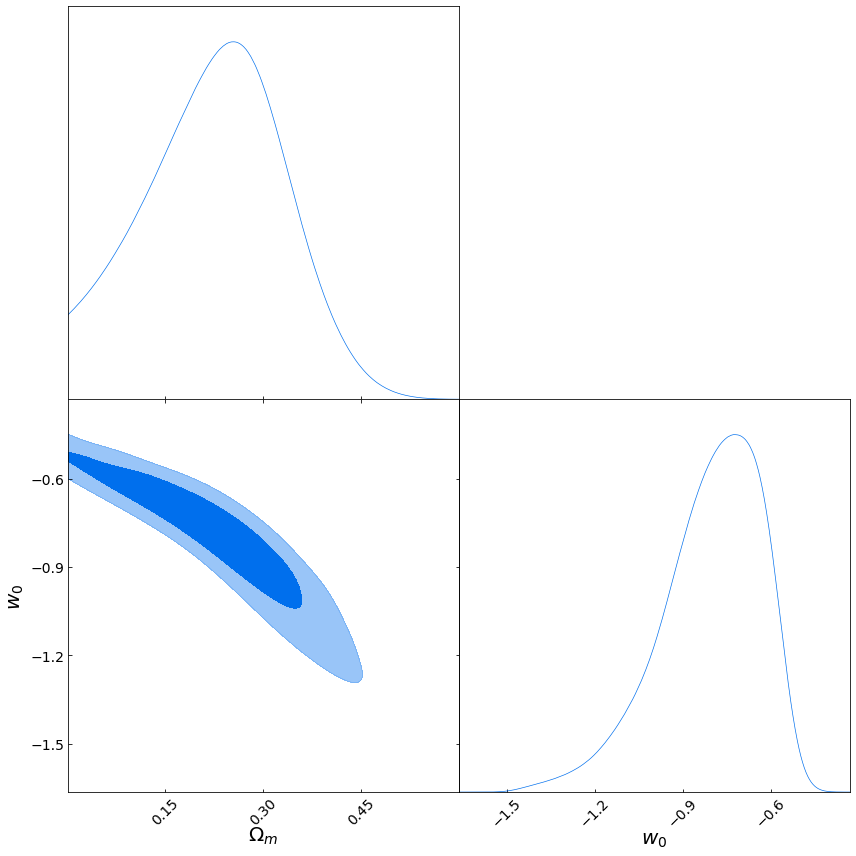

Population 11/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2160 samples, validate on 240 samples
Epoch 1/100
2160/2160 [==============================] - 10s 4ms/step - loss: 1.3150 - val_loss: 1.3895
Epoch 2/100
2160/2160 [==============================] - 8s 4ms/step - loss: 1.3129 - val_loss: 1.4084
Epoch 3/100
2160/2160 [==============================] - 6s 3ms/step - loss: 1.3167 - val_loss: 1.4083
Epoch 4/100
2160/2160 [==============================] - 7s 3ms/step - loss: 1.3167 - val_loss: 1.4074
Epoch 5/100
2160/2160 [==============================] - 10s 5ms/step - loss: 1.3151 - val_loss: 1.3870
Epoch 6/100
2160/2160 [==============================] - 10s 4ms/step - loss: 1.3122 - val_loss: 1.4152
Epoch 7/100
2160/2160 [==============================] - 7s 3ms/step - loss: 1.3114 - val_loss: 1.3921
Epoch 8/100
2160/2160 [==============================] - 6s 3ms/step - loss: 1.3159 - val_loss: 1.3944
Epoch 9/100
2160/2160 [=========================

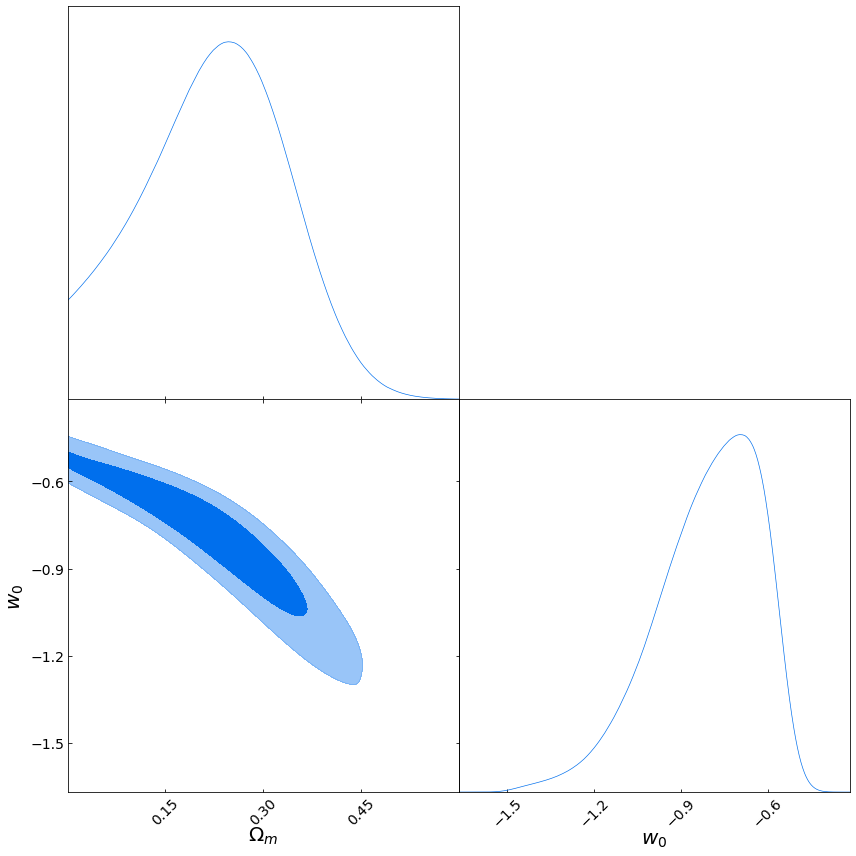

Population 12/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2340 samples, validate on 260 samples
Epoch 1/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3203 - val_loss: 1.3252
Epoch 2/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3253 - val_loss: 1.3478
Epoch 3/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3237 - val_loss: 1.3230
Epoch 4/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3221 - val_loss: 1.3098
Epoch 5/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3270 - val_loss: 1.3394
Epoch 6/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3176 - val_loss: 1.3145
Epoch 7/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3183 - val_loss: 1.3273
Epoch 8/100
2340/2340 [==============================] - 3s 1ms/step - loss: 1.3177 - val_loss: 1.3306
Epoch 9/100
2340/2340 [============================

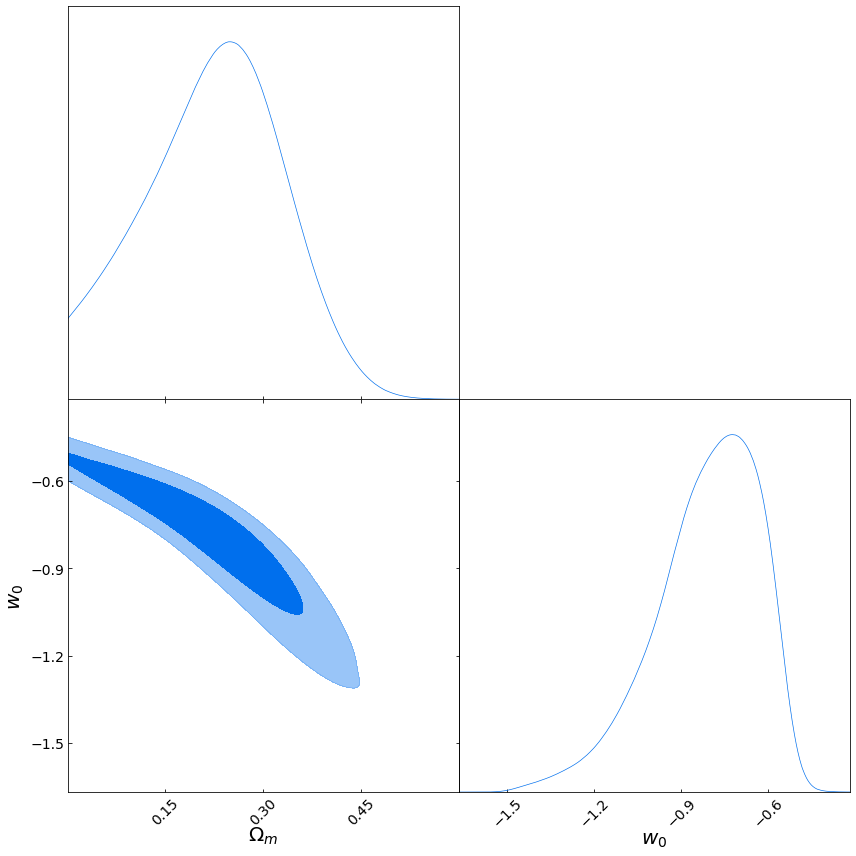

Population 13/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2520 samples, validate on 280 samples
Epoch 1/100
2520/2520 [==============================] - 4s 2ms/step - loss: 1.3202 - val_loss: 1.2550
Epoch 2/100
2520/2520 [==============================] - 3s 1ms/step - loss: 1.3277 - val_loss: 1.2471
Epoch 3/100
2520/2520 [==============================] - 3s 1ms/step - loss: 1.3243 - val_loss: 1.2407
Epoch 4/100
2520/2520 [==============================] - 3s 1ms/step - loss: 1.3235 - val_loss: 1.2466
Epoch 5/100
2520/2520 [==============================] - 3s 1ms/step - loss: 1.3315 - val_loss: 1.2545
Epoch 6/100
2520/2520 [==============================] - 3s 1ms/step - loss: 1.3281 - val_loss: 1.2491
Epoch 7/100
2520/2520 [==============================] - 3s 1ms/step - loss: 1.3229 - val_loss: 1.2453
Epoch 8/100
2520/2520 [==============================] - 3s 1ms/step - loss: 1.3231 - val_loss: 1.2466
Epoch 9/100
2520/2520 [============================

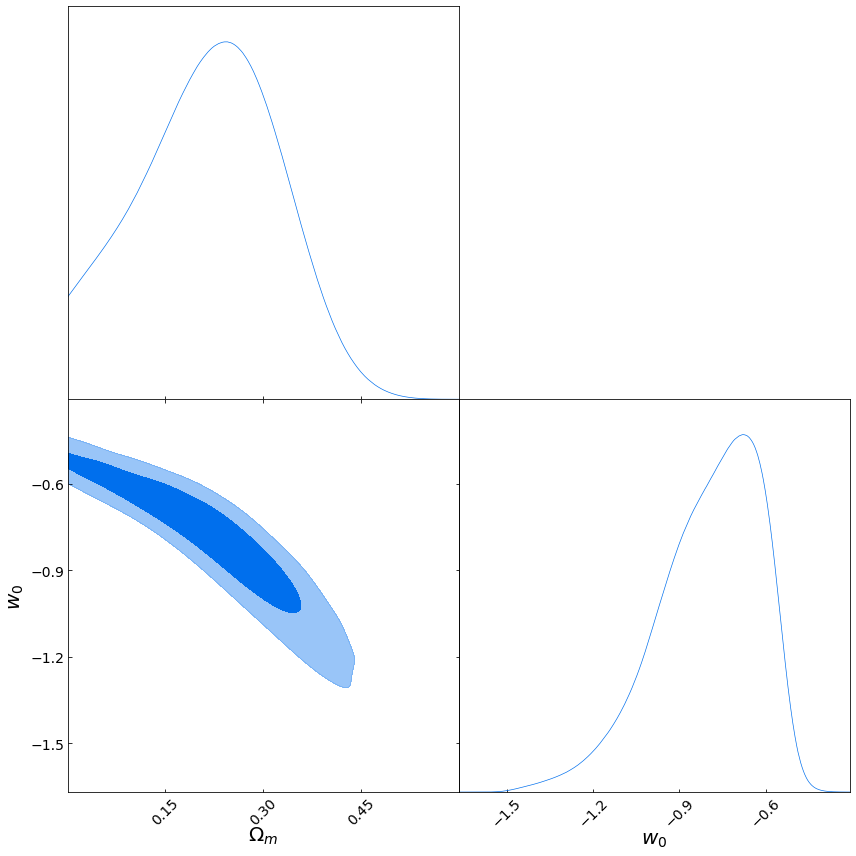

Population 14/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3144 - val_loss: 1.4025
Epoch 2/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3164 - val_loss: 1.4038
Epoch 3/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3125 - val_loss: 1.4061
Epoch 4/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3124 - val_loss: 1.4029
Epoch 5/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3136 - val_loss: 1.4037
Epoch 6/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3138 - val_loss: 1.3962
Epoch 7/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3132 - val_loss: 1.3977
Epoch 8/100
2700/2700 [==============================] - 4s 1ms/step - loss: 1.3150 - val_loss: 1.4052
Epoch 9/100
2700/2700 [============================

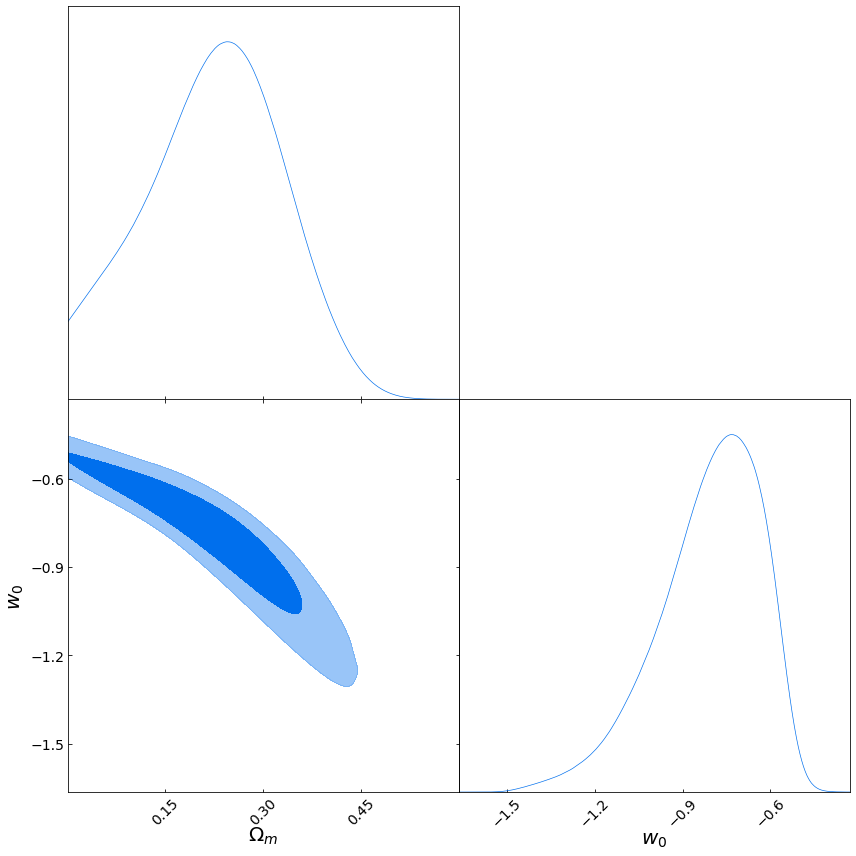

Population 15/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 2880 samples, validate on 320 samples
Epoch 1/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3193 - val_loss: 1.3272
Epoch 2/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3251 - val_loss: 1.3348
Epoch 3/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3199 - val_loss: 1.3309
Epoch 4/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3234 - val_loss: 1.3357
Epoch 5/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3189 - val_loss: 1.3296
Epoch 6/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3215 - val_loss: 1.3348
Epoch 7/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3166 - val_loss: 1.3356
Epoch 8/100
2880/2880 [==============================] - 4s 1ms/step - loss: 1.3249 - val_loss: 1.3449
Epoch 9/100
2880/2880 [============================

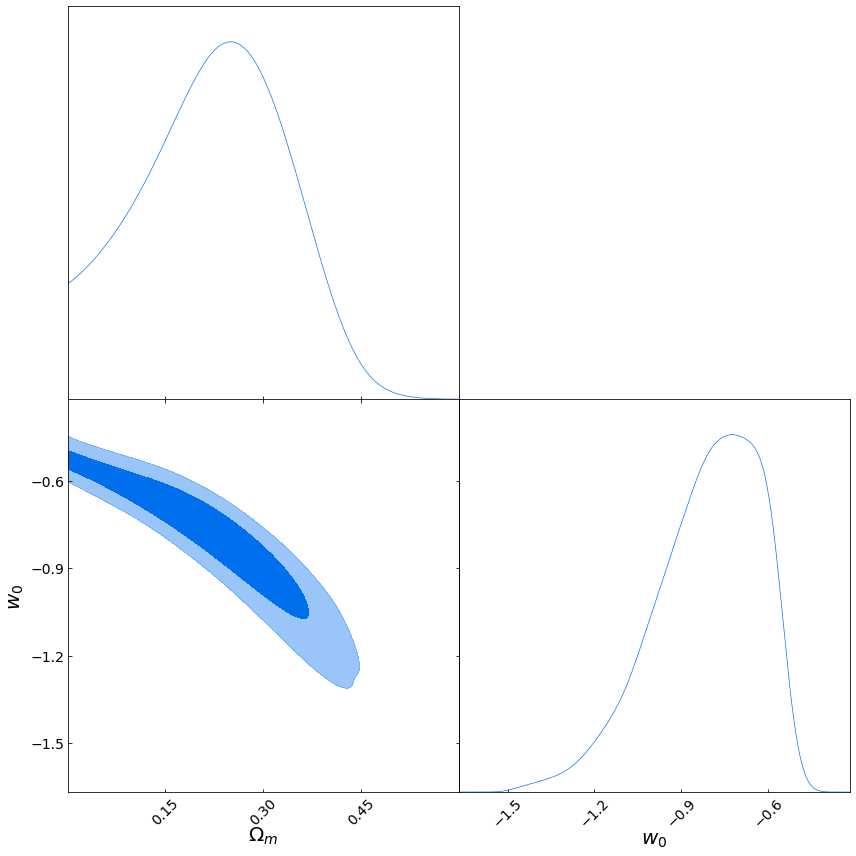

Population 16/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3060 samples, validate on 340 samples
Epoch 1/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3192 - val_loss: 1.3584
Epoch 2/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3231 - val_loss: 1.3445
Epoch 3/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3197 - val_loss: 1.3401
Epoch 4/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3197 - val_loss: 1.3468
Epoch 5/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3179 - val_loss: 1.3373
Epoch 6/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3160 - val_loss: 1.3367
Epoch 7/100
3060/3060 [==============================] - 4s 1ms/step - loss: 1.3186 - val_loss: 1.3356
Epoch 8/100
3060/3060 [==============================] - 5s 1ms/step - loss: 1.3204 - val_loss: 1.3470
Epoch 9/100
3060/3060 [============================

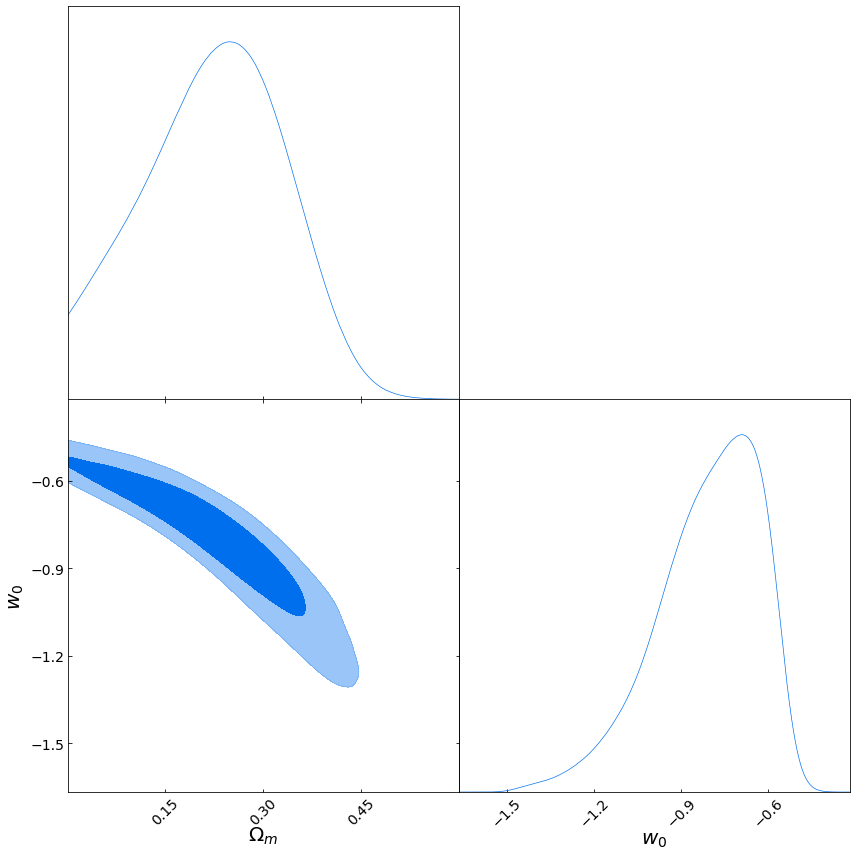

Population 17/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3240 samples, validate on 360 samples
Epoch 1/100
3240/3240 [==============================] - 5s 1ms/step - loss: 1.3151 - val_loss: 1.3224
Epoch 2/100
3240/3240 [==============================] - 4s 1ms/step - loss: 1.3145 - val_loss: 1.3279
Epoch 3/100
3240/3240 [==============================] - 4s 1ms/step - loss: 1.3125 - val_loss: 1.3215
Epoch 4/100
3240/3240 [==============================] - 4s 1ms/step - loss: 1.3124 - val_loss: 1.3245
Epoch 5/100
3240/3240 [==============================] - 4s 1ms/step - loss: 1.3116 - val_loss: 1.3276
Epoch 6/100
3240/3240 [==============================] - 4s 1ms/step - loss: 1.3133 - val_loss: 1.3242
Epoch 7/100
3240/3240 [==============================] - 4s 1ms/step - loss: 1.3156 - val_loss: 1.3271
Epoch 8/100
3240/3240 [==============================] - 4s 1ms/step - loss: 1.3146 - val_loss: 1.3278
Epoch 9/100
3240/3240 [============================

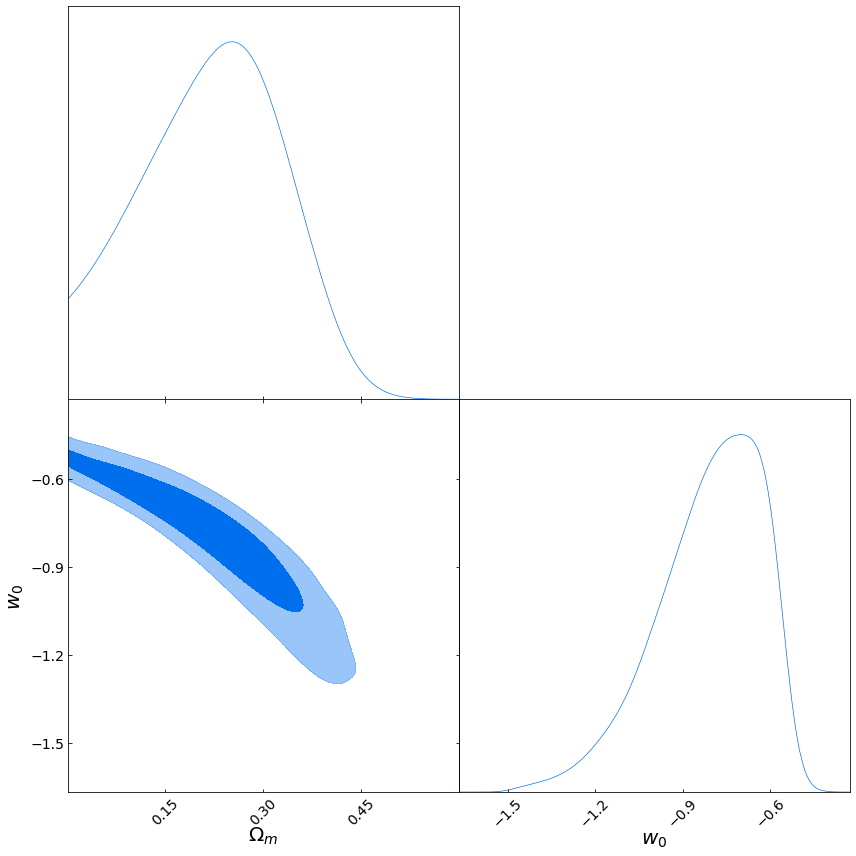

Population 18/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3420 samples, validate on 380 samples
Epoch 1/100
3420/3420 [==============================] - 7s 2ms/step - loss: 1.3191 - val_loss: 1.3275
Epoch 2/100
3420/3420 [==============================] - 7s 2ms/step - loss: 1.3189 - val_loss: 1.3377
Epoch 3/100
3420/3420 [==============================] - 7s 2ms/step - loss: 1.3180 - val_loss: 1.3301
Epoch 4/100
3420/3420 [==============================] - 7s 2ms/step - loss: 1.3181 - val_loss: 1.3420
Epoch 5/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3225 - val_loss: 1.3334
Epoch 6/100
3420/3420 [==============================] - 6s 2ms/step - loss: 1.3204 - val_loss: 1.3350
Epoch 7/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3223 - val_loss: 1.3470
Epoch 8/100
3420/3420 [==============================] - 5s 1ms/step - loss: 1.3181 - val_loss: 1.3344
Epoch 9/100
3420/3420 [============================

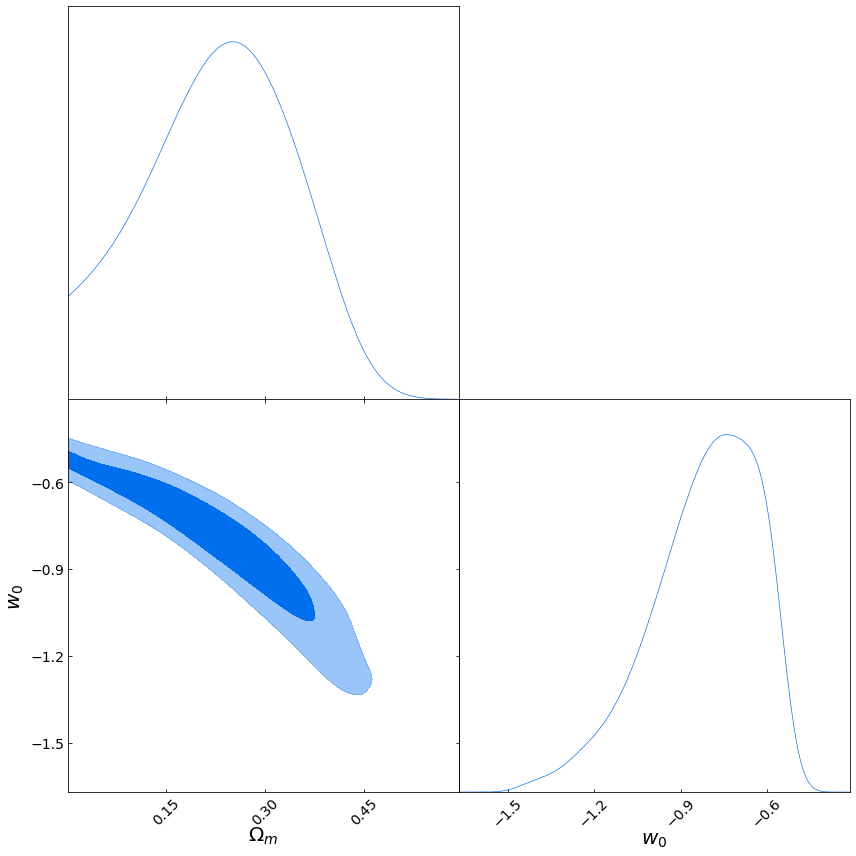

Population 19/19
Sampling proposal density...
Done.
Running 200 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3182 - val_loss: 1.3884
Epoch 2/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3143 - val_loss: 1.3946
Epoch 3/100
3600/3600 [==============================] - 6s 2ms/step - loss: 1.3165 - val_loss: 1.4036
Epoch 4/100
3600/3600 [==============================] - 6s 2ms/step - loss: 1.3136 - val_loss: 1.3987
Epoch 5/100
3600/3600 [==============================] - 8s 2ms/step - loss: 1.3149 - val_loss: 1.3944
Epoch 6/100
3600/3600 [==============================] - 11s 3ms/step - loss: 1.3187 - val_loss: 1.4071
Epoch 7/100
3600/3600 [==============================] - 9s 3ms/step - loss: 1.3185 - val_loss: 1.3889
Epoch 8/100
3600/3600 [==============================] - 5s 1ms/step - loss: 1.3192 - val_loss: 1.3904
Epoch 9/100
3600/3600 [===========================

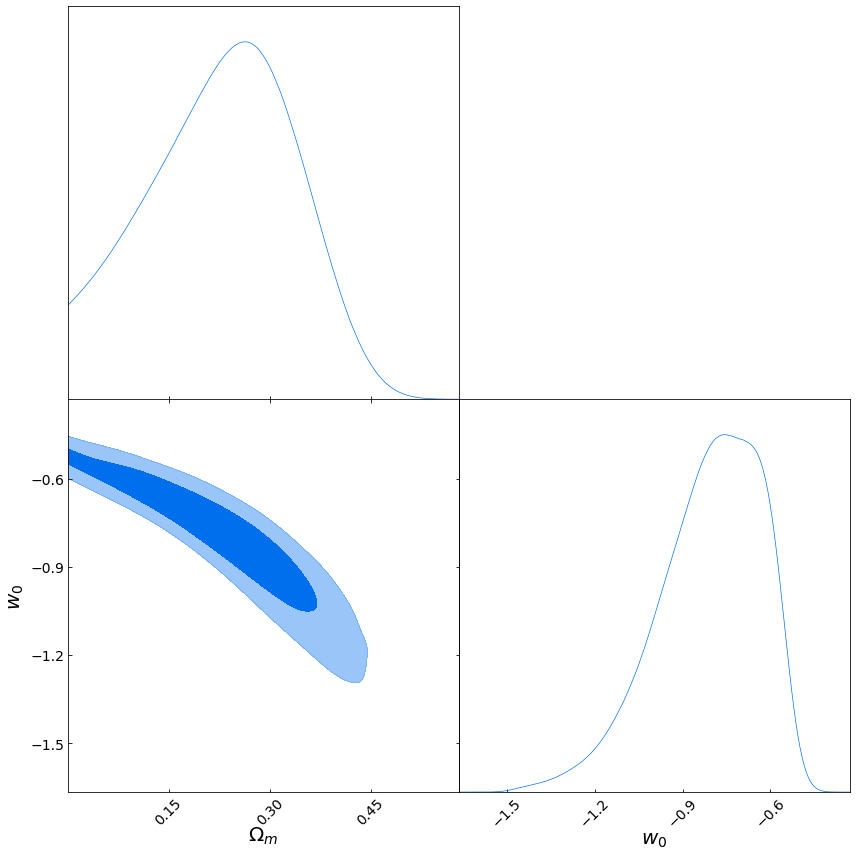

Final round of training with larger SGD batch size...
Train on 3600 samples, validate on 400 samples
Epoch 1/300
3600/3600 [==============================] - 9s 3ms/step - loss: 1.3125 - val_loss: 1.4060
Epoch 2/300
3600/3600 [==============================] - 11s 3ms/step - loss: 1.3156 - val_loss: 1.4059
Epoch 3/300
3600/3600 [==============================] - 11s 3ms/step - loss: 1.3153 - val_loss: 1.4007
Epoch 4/300
3600/3600 [==============================] - 11s 3ms/step - loss: 1.3122 - val_loss: 1.3947
Epoch 5/300
3600/3600 [==============================] - 9s 2ms/step - loss: 1.3098 - val_loss: 1.3911
Epoch 6/300
3600/3600 [==============================] - 10s 3ms/step - loss: 1.3100 - val_loss: 1.3901
Epoch 7/300
3600/3600 [==============================] - 10s 3ms/step - loss: 1.3117 - val_loss: 1.3902
Epoch 8/300
3600/3600 [==============================] - 10s 3ms/step - loss: 1.3127 - val_loss: 1.3903
Epoch 9/300
3600/3600 [==============================] - 11s 3ms/step

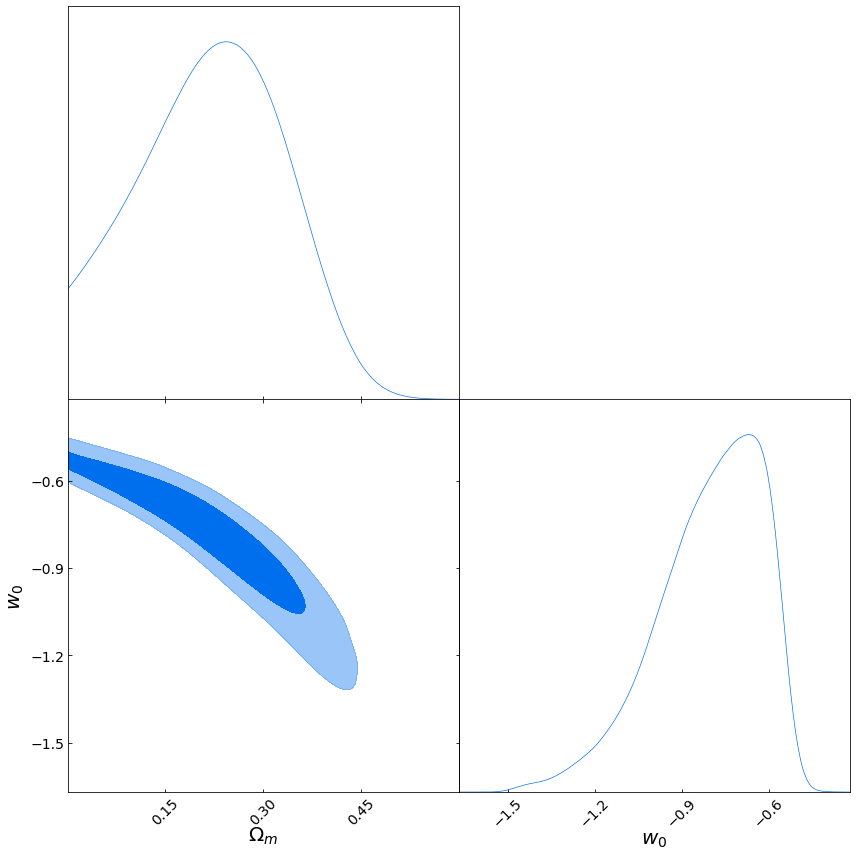

In [7]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 200
n_batch = 200
n_populations = 19

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

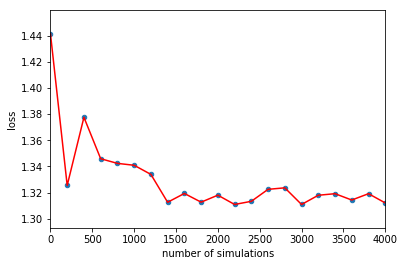

In [9]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()